# PHE SEIR Model Paper results

In this notebook we present how to use the `epimodels` module to reproduce the results in the paper introducing the PHE model:
 - **Figure 2**: predicted numbers of infections and deaths by efficacy of social restriction measures (*here encoded through the reduction in transmission*);
 - **Figure 3**: parameter inference for the initial R number and the transmission time-varying beta parameters.

The analyses are run for:
 - Dates: **15 Feb 2020** - **25 June 2020**;
 - PHE regions of interest: **London**, **North West**, **Outside London**.

We use realistic serology and mortality data extracted from the REACT survey and GOV.UK data.

*The PHE model is built by Public Health England in collaboration with University of Cambridge.*

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

# Set random seed
np.random.seed(27)

# _Figure 2_

## Estimated and projected COVID-19 infections and deaths by efficacy of social restriction measures

- use different multiplier for the contact changes to encode the effect of social restriction measures.
- Dates: **15 Feb 2020** - **25 June 2020**;
- PHE regions of interest: **London** & **Outside London**

## Model Setup
### Define setup matrices for the PHE Model

In [2]:
# Populate the model
total_days =  132

outside_london = ['EE', 'Mid', 'NE', 'NW', 'SE', 'SW']
regions = ['London', 'Outside London']

age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
matrices_region = []

### Variable
# Initial state of the system
for w in weeks:
    weeks_matrices_region = []
    for r in regions:
        if r == 'London':
            path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
            region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
        else:
            for oth_reg in outside_london:
                path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(oth_reg, w))
                region_data_matrix += pd.read_csv(path, header=None, dtype=np.float64)
            region_data_matrix = region_data_matrix / len(outside_london)
        
        regional = em.RegionMatrix(r, age_groups, region_data_matrix)
        weeks_matrices_region.append(regional)

    matrices_region.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = np.arange(1, total_days+1, 7).tolist()

### Fixed
# # Initial state of the system
# weeks_matrices_region = []
# for r in regions:
#     path = os.path.join('../../data/final_contact_matrices/BASE.csv')
#     region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#     regional = em.RegionMatrix(r, age_groups, region_data_matrix)
#     weeks_matrices_region.append(regional)

# matrices_region.append(weeks_matrices_region)

# contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
# matrices_contact = [contacts]

# # Matrices contact
# time_changes_contact = [1]
# time_changes_region = [1]

### Set the parameters and initial conditions of the model and bundle everything together

In [3]:
# Instantiate model
model = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
model.set_regions(regions)
model.set_age_groups(age_groups)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)

# Initial number of susceptibles
ath = os.path.join('../../data/england_population/England_population.csv')
susceptibles_array = np.loadtxt(path, dtype=int, delimiter=',').tolist()

susceptibles = [
    susceptibles_array[1,:].tolist(),
    np.sum(np.delete(susceptibles_array, [1], axis=0), axis=0).tolist()]

# Initial number of infectives
ICs_multiplier = [50, 200]
infectives1 = [
    [ICs_multiplier[0]] * len(age_groups),
    [ICs_multiplier[1]] * len(age_groups)
]

infectives2 = np.zeros((len(regions), len(age_groups))).tolist()

dI = 4
dL = 4

# Initial R number by region
initial_r = 2.50837101*np.ones(len(regions))

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

## Read Death and Serology data

In [4]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    if region == 'London':
        deaths_data.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
        positives_data.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
        tests.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))
    else:
        OUTLON_deaths_data = 0
        OUTLON_positives_data = 0
        OUTLON_tests = 0
        for oth_reg in outside_london:
            OUTLON_deaths_data += np.loadtxt('../../data/death_data/{}_deaths.csv'.format(oth_reg), dtype=int, delimiter=',')
            OUTLON_positives_data += np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(oth_reg), dtype=int, delimiter=',')
            OUTLON_tests += np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(oth_reg), dtype=int, delimiter=',')
        deaths_data.append(OUTLON_deaths_data)
        positives_data.append(OUTLON_positives_data)
        tests.append(OUTLON_tests)


In [5]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [6]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = (1/100 * np.array([0.0016, 0.0016, 0.0043, 0.019, 0.08975, 0.815, 3.1, 6.05])).tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

## Compute mean and bounderies for the CI for the trajectories of new infections and deaths

In [7]:
num_iterations = 1000
niu = 5

population = np.sum(np.asarray(susceptibles), axis=1)

# Values of reduction in contacts
reduction = [0.24, 0.48, 0.64]

deaths_mean = []
deaths_upper = []
deaths_lower = []

new_infec_mean = []
new_infec_upper = []
new_infec_lower = []

for red in reduction:
    red_deaths_mean = []
    red_deaths_upper = []
    red_deaths_lower = []

    red_new_infec_mean = []
    red_new_infec_upper = []
    red_new_infec_lower = []

    multiplier = 1-red

    # Reduction in contacts is applied from 23rd of March (day 44)
    betas = np.ones((len(regions), len(times)))
    betas[:, 44:] = multiplier
    betas.tolist()

    for r, reg in enumerate(regions):
        reg_deaths_data = np.empty((num_iterations, len(times)))
        reg_new_infect_data = np.empty((num_iterations, len(times)))
        for iter in range(num_iterations):
            # List of common initial conditions and parameters that characterise the fixed and variable model
            parameters = [
                initial_r, r+1, susceptibles, np.zeros((len(regions), len(age_groups))).tolist(), np.zeros((len(regions), len(age_groups))).tolist(),
                infectives1, infectives2, np.zeros((len(regions), len(age_groups))).tolist(), betas, dL, dI, 0.5]

            # Simulate using the ODE solver from scipy
            scipy_method = 'RK45'
            parameters.append(scipy_method)

            red_output_scipy_solver = model.simulate(list(deepflatten(parameters, ignore=str)), times)
            red_new_infec_scipy_solver = model.new_infections(red_output_scipy_solver)

            # Sample death results data for all regions
            for t, _ in enumerate(times):
                reg_deaths_data[iter, t] = 1e5 * np.sum(model.samples_deaths(red_new_infec_scipy_solver, fatality_ratio, time_to_death, niu, t)) / population[r]
                reg_new_infect_data[iter, t] = 1e5 * np.sum(model.samples_positive_tests(red_output_scipy_solver, tests[r], sens, spec, t)) / population[r]
            
        red_deaths_mean.append(np.mean(reg_deaths_data, axis=0))
        red_deaths_upper.append(np.quantile(reg_deaths_data, 0.975, axis=0))
        red_deaths_lower.append(np.quantile(reg_deaths_data, 0.025, axis=0))

        red_new_infec_mean.append(np.mean(reg_new_infect_data, axis=0))
        red_new_infec_upper.append(np.quantile(reg_new_infect_data, 0.975, axis=0))
        red_new_infec_lower.append(np.quantile(reg_new_infect_data, 0.025, axis=0))

    deaths_mean.append(red_deaths_mean)
    deaths_upper.append(red_deaths_upper)
    deaths_lower.append(red_deaths_lower)

    new_infec_mean.append(red_new_infec_mean)
    new_infec_upper.append(red_new_infec_upper)
    new_infec_lower.append(red_new_infec_lower)

### Plot the mean and CI boundaries for the number of deaths and infections for the different levels of reduction in transmission

In [8]:
from plotly.subplots import make_subplots

colours = ['red', 'blue']
trace_name = regions

fig = go.Figure()
fig = make_subplots(rows=2, cols=len(reduction), horizontal_spacing = 0.15, shared_yaxes=True)

# Plot (bar chart cases each day)
for Reg, region in enumerate(regions):
    for r, red in enumerate(reduction):
        if r != 0:
            # Plot of new infections
            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=new_infec_mean[r][Reg].tolist(),
                    mode='lines',
                    name=trace_name[Reg],
                    showlegend=False,
                    line_color=colours[Reg],
                    line={'dash': 'dot'}
                ),
                row= 1,
                col= r+1
            )

            fig.add_trace(
                go.Scatter(
                    x=times + times[::-1],
                    y=new_infec_upper[r][Reg].tolist() + new_infec_lower[r][Reg].tolist()[::-1],
                    fill='toself',
                    fillcolor=colours[Reg],
                    line_color=colours[Reg],
                    opacity=0.15,
                    mode='lines',
                    showlegend=False,
                    name=trace_name[Reg]
                ),
                row= 1,
                col= r+1
            )
        
        else:
            # Plot of new infections
            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=new_infec_mean[r][Reg].tolist(),
                    mode='lines',
                    name=trace_name[Reg],
                    line_color=colours[Reg],
                    line={'dash': 'dot'}
                ),
                row= 1,
                col= r+1
            )

            fig.add_trace(
                go.Scatter(
                    x=times + times[::-1],
                    y=new_infec_upper[r][Reg].tolist() + new_infec_lower[r][Reg].tolist()[::-1],
                    fill='toself',
                    fillcolor=colours[Reg],
                    line_color=colours[Reg],
                    opacity=0.15,
                    mode='lines',
                    showlegend=False,
                    name=trace_name[Reg]
                ),
                row= 1,
                col= r+1
            )

        # Plot of deaths
        fig.add_trace(
            go.Scatter(
                x=times,
                y=deaths_mean[r][Reg].tolist(),
                mode='lines',
                name=trace_name[Reg],
                line_color=colours[Reg],
                showlegend=False,
                line={'dash': 'dot'}
            ),
            row= 2,
            col= r+1
        )

        fig.add_trace(
            go.Scatter(
                x=times + times[::-1],
                y=deaths_upper[r][Reg].tolist() + deaths_lower[r][Reg].tolist()[::-1],
                fill='toself',
                fillcolor=colours[Reg],
                line_color=colours[Reg],
                opacity=0.15,
                mode='lines',
                showlegend=False,
                name=trace_name[Reg]
            ),
            row= 2,
            col= r+1
        )

        fig.update_xaxes(
            row=1, col=r+1, title_text='New infections<br>{} reduction in transmission'.format(red),
            ticks='inside', tickcolor='black', ticklen=5)
        fig.update_xaxes(
            row=2, col=r+1, title_text='Deaths<br>{} reduction in transmission'.format(red),
            ticks='inside', tickcolor='black', ticklen=5)
        fig.update_yaxes(ticks='outside', tickcolor='black', ticklen=7.5)
        

# Add axis labels
fig.update_layout(
    width=1200, 
    height=950,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    xaxis4=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis4=dict(linecolor='black'),
    xaxis5=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis5=dict(linecolor='black'),
    xaxis6=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis6=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-2.pdf')
fig.show()

# _Figure 3_

## Uncertainty in trajectories of COVID-19 infections, deaths and reproduction number using baseline contact matrices
- Dates: **15 Feb 2020** - **25 June 2020**;
- PHE regions of interest: **London** & **North West**

*Best way to do the inference is to run the procedure for each region separately, by instantiating two distinct PHE models.*

## Model Setup
### Define setup matrices for the PHE Models

In [9]:
# Populate the model
total_days =  132
regions_LON = ['London']
regions_NW = ['NW']

regions = regions_LON + regions_NW

age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
matrices_region_LON = []
matrices_region_NW = []

### Variable
# Initial state of the system
for w in weeks:
    # London
    weeks_matrices_region = []
    for r in regions_LON:
        path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
        region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
        regional = em.RegionMatrix(r, age_groups, region_data_matrix)
        weeks_matrices_region.append(regional)

    matrices_region_LON.append(weeks_matrices_region)

    # North West
    weeks_matrices_region = []
    for r in regions_NW:
        path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
        region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
        regional = em.RegionMatrix(r, age_groups, region_data_matrix)
        weeks_matrices_region.append(regional)

    matrices_region_NW.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = np.arange(1, total_days+1, 7).tolist()

### Fixed
# # Initial state of the system
# # London
# weeks_matrices_region = []
# for r in regions_LON:
#     path = os.path.join('../../data/final_contact_matrices/BASE.csv')
#     region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#     regional = em.RegionMatrix(r, age_groups, region_data_matrix)
#     weeks_matrices_region.append(regional)

# matrices_region_LON.append(weeks_matrices_region)

# # North West
# for r in regions_NW:
#     path = os.path.join('../../data/final_contact_matrices/BASE.csv')
#     region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#     regional = em.RegionMatrix(r, age_groups, region_data_matrix)

# matrices_region_NW.append(weeks_matrices_region)

# contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
# matrices_contact = [contacts]

# # Matrices contact
# time_changes_contact = [1]
# time_changes_region = [1]

### Set the parameters and initial conditions of the models and bundle everything together to simulate

In [10]:
# Instantiate model for London
model_LON = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
model_LON.set_regions(regions_LON)
model_LON.set_age_groups(age_groups)
model_LON.read_contact_data(matrices_contact, time_changes_contact)
model_LON.read_regional_data(matrices_region_LON, time_changes_region)

# Instantiate model for North West
model_NW = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
model_NW.set_regions(regions_NW)
model_NW.set_age_groups(age_groups)
model_NW.read_contact_data(matrices_contact, time_changes_contact)
model_NW.read_regional_data(matrices_region_NW, time_changes_region)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = [total_susceptibles[index] for index in [1, 4]]

# Initial number of infectives
ICs_multiplier = [50, 30]
infectives1 = [
    [ICs_multiplier[0]] * len(age_groups),
    [ICs_multiplier[1]] * len(age_groups)
]
infectives2 = np.zeros((2, len(age_groups))).tolist()

dI = 4
dL = 4

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

## Read Death and Serology data

In [11]:
# Read in death and positive data from external files for London
deaths_data_LON = []
positives_data_LON = []
tests_LON = []

for region in regions_LON:
    deaths_data_LON.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data_LON.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests_LON.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))

# Read in death and positive data from external files for North West
deaths_data_NW = []
positives_data_NW = []
tests_NW = []

for region in regions_NW:
    deaths_data_NW.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data_NW.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests_NW.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))

deaths_data = deaths_data_LON + deaths_data_NW
positives_data = positives_data_LON + positives_data_NW
tests = tests_LON + tests_NW

In [12]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [13]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = (1/100 * np.array([0.0016, 0.0016, 0.0043, 0.019, 0.08975, 0.815, 3.1, 6.05])).tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

## Inference Procedure

In [14]:
## Initialise inference for the model for London
phe_inference_LON = em.inference.PheSEIRInfer(model_LON)

# Add model, death and tests data to the inference structure
phe_inference_LON.read_model_data([susceptibles[0]], [infectives1[0]])
phe_inference_LON.read_deaths_data(deaths_data_LON, deaths_times, time_to_death, fatality_ratio)
phe_inference_LON.read_serology_data(tests_LON, positives_data_LON, serology_times, sens, spec)

# Run inference structure
samples_LON = phe_inference_LON.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Time m:s
0     12     -7390.739   0:01.0
1     24     -7364.256   0:02.0
2     36     -7121.148   0:02.9
3     48     -6836.053   0:03.8


/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:309: RuntimeWarning:

invalid value encountered in log

/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:310: RuntimeWarning:

invalid value encountered in log



20    252    -3132.907   0:20.7
40    492    -2997.588   0:42.9
60    732    -2896.39    1:04.5
80    972    -2841.601   1:25.4
100   1212   -2809.46    1:45.6
120   1452   -2789.435   2:06.0
140   1692   -2782.422   2:26.0
160   1932   -2778.159   2:45.6
180   2172   -2776.137   3:04.6
200   2412   -2775.259   3:23.7
220   2652   -2774.679   3:42.4
240   2892   -2774.466   4:01.2
249   2988   -2774.432   4:08.7
Halting: No significant change for 100 iterations.
[3.27966974 0.51931309 0.33725694 0.34384269 0.41936232 0.48871995
 0.48910859 0.48873426 0.4747067  0.46374145 0.48126069 0.49427475
 0.53069622 0.56467189 0.15564002] -2774.431975566467
Optimisation phase is finished.
Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in parallel with 3 worker processess.
Iter. Eval.  Accept.   Accept.   Accept.   Time m:s
0     3       0         0         0          0:01.9
1     6       0         0         0          0:02.0
2     9       0         0       

In [15]:
## Initialise inference for the model for North West
phe_inference_NW = em.inference.PheSEIRInfer(model_NW)

# Add model, death and tests data to the inference structure
phe_inference_NW.read_model_data([susceptibles[0]], [infectives1[0]])
phe_inference_NW.read_deaths_data(deaths_data_NW, deaths_times, time_to_death, fatality_ratio)
phe_inference_NW.read_serology_data(tests_NW, positives_data_NW, serology_times, sens, spec)

# Run inference structure
samples_NW = phe_inference_NW.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Time m:s
0     12     -6705.962   0:01.0
1     24     -6624.326   0:01.9
2     36     -6529.97    0:02.8
3     48     -6509.231   0:03.8
20    252    -3972.095   0:20.2
40    492    -3914.062   0:40.8
60    732    -3903.33    1:01.2
80    972    -3874.917   1:21.3
100   1212   -3867.358   1:40.9
120   1452   -3864.362   2:00.5
140   1692   -3862.856   2:19.8
160   1932   -3862.42    2:38.7
180   2172   -3861.74    2:57.7
200   2412   -3861.453   3:16.7
219   2628   -3860.995   3:33.7
Halting: No significant change for 100 iterations.
[2.74172168 1.30654933 0.52965723 0.34251699 0.48998874 0.65094028
 0.65768361 0.60881386 0.58838156 0.5585945  0.54763143 0.58308083
 0.63947804 0.75702779 0.19667374] -3860.995394989305
Optimisation phase is finished.
Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running i

### Quality check of the inference procedure

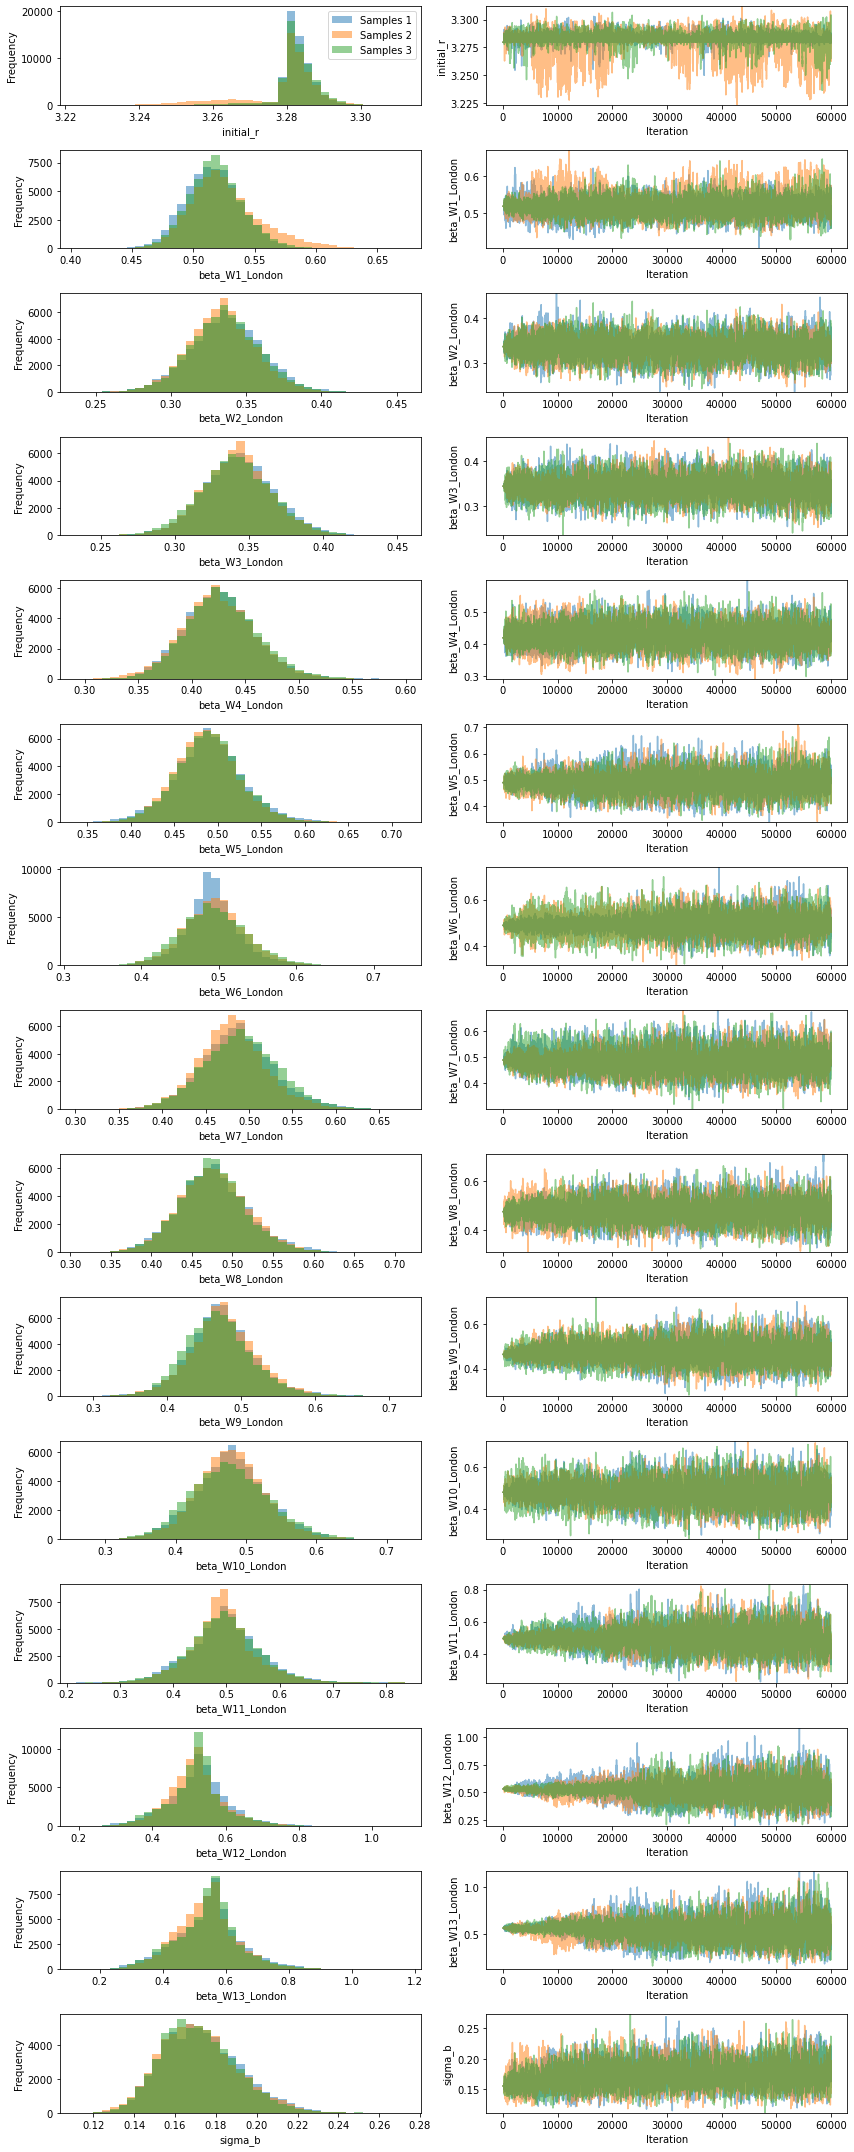

In [16]:
import pints.plot

# Plot histograms of the parameters inferred for London
param_names = ['initial_r']
param_names.extend(['beta_W{}_London'.format(i+1) for i in range(len(np.arange(44, len(times), 7)))])
param_names.extend(['sigma_b'])

pints.plot.trace(samples_LON, parameter_names=param_names)
plt.show()

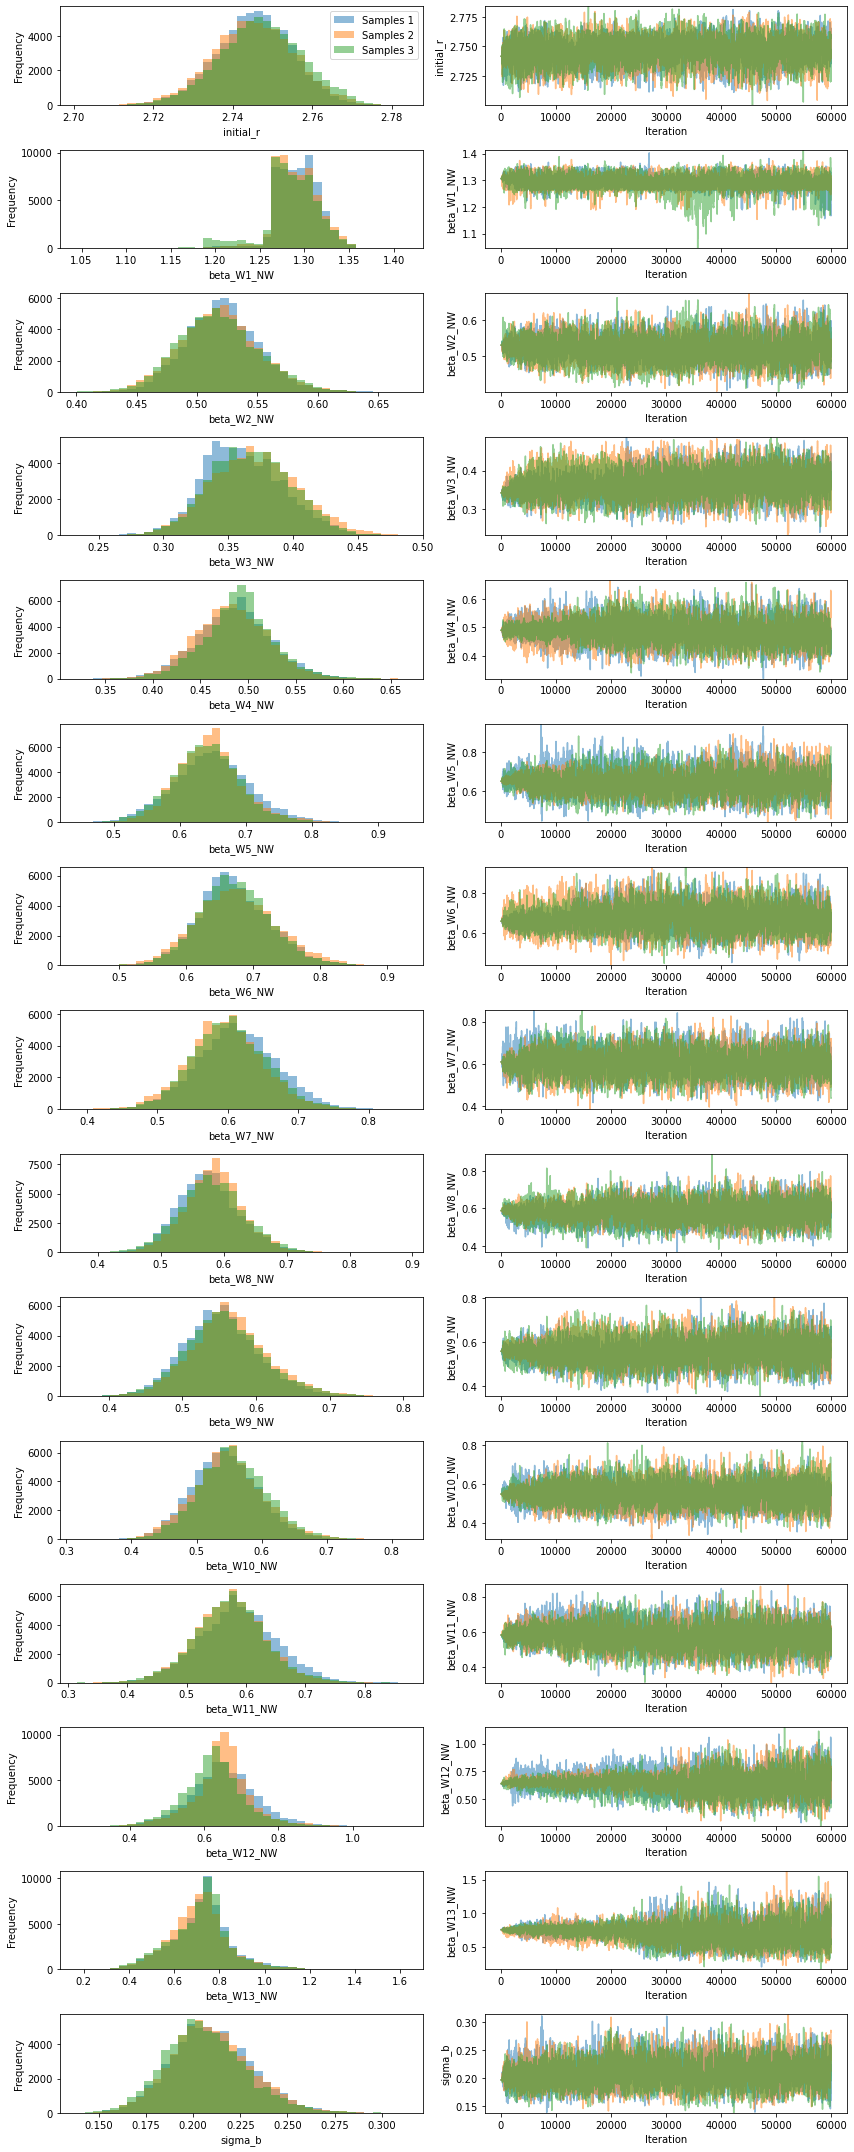

In [17]:
# Plot histograms of the parameters inferred for North West
param_names = ['initial_r']
param_names.extend(['beta_W{}_NW'.format(i+1) for i in range(len(np.arange(44, len(times), 7)))])
param_names.extend(['sigma_b'])

pints.plot.trace(samples_NW, parameter_names=param_names)
plt.show()

In [18]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
samples_LON = samples_LON[:, 30000:, :]
samples_NW = samples_NW[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(samples_LON))
print(pints.rhat(samples_NW))

[1.04695112 1.02743048 1.00242076 1.00155071 1.00483274 1.00139935
 1.00184385 1.00221742 1.00519725 1.00587203 1.00066602 1.00079685
 1.00164633 1.00262699 1.00473207]
[1.01095232 1.02992407 1.00274639 1.00962107 1.00405426 1.01405903
 1.00397814 1.00662943 1.00124088 1.00197121 1.00835713 1.00393575
 1.0045821  1.00265422 1.01011924]


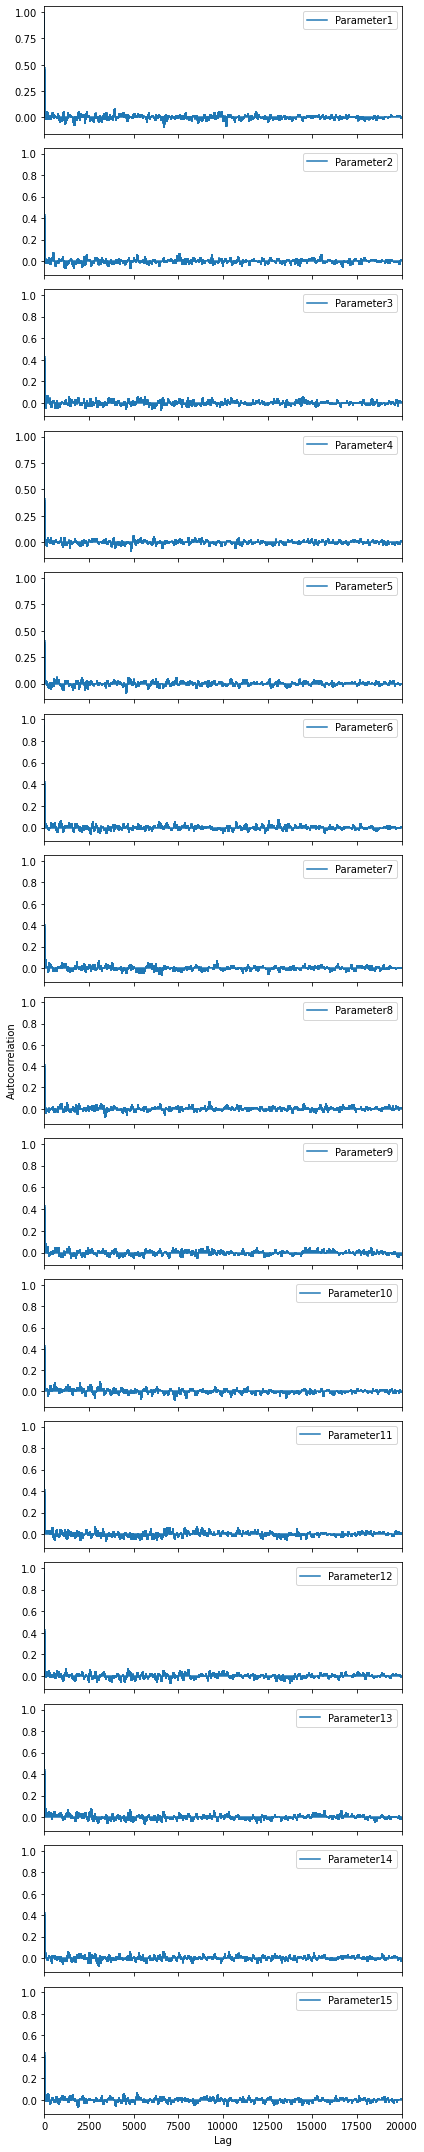

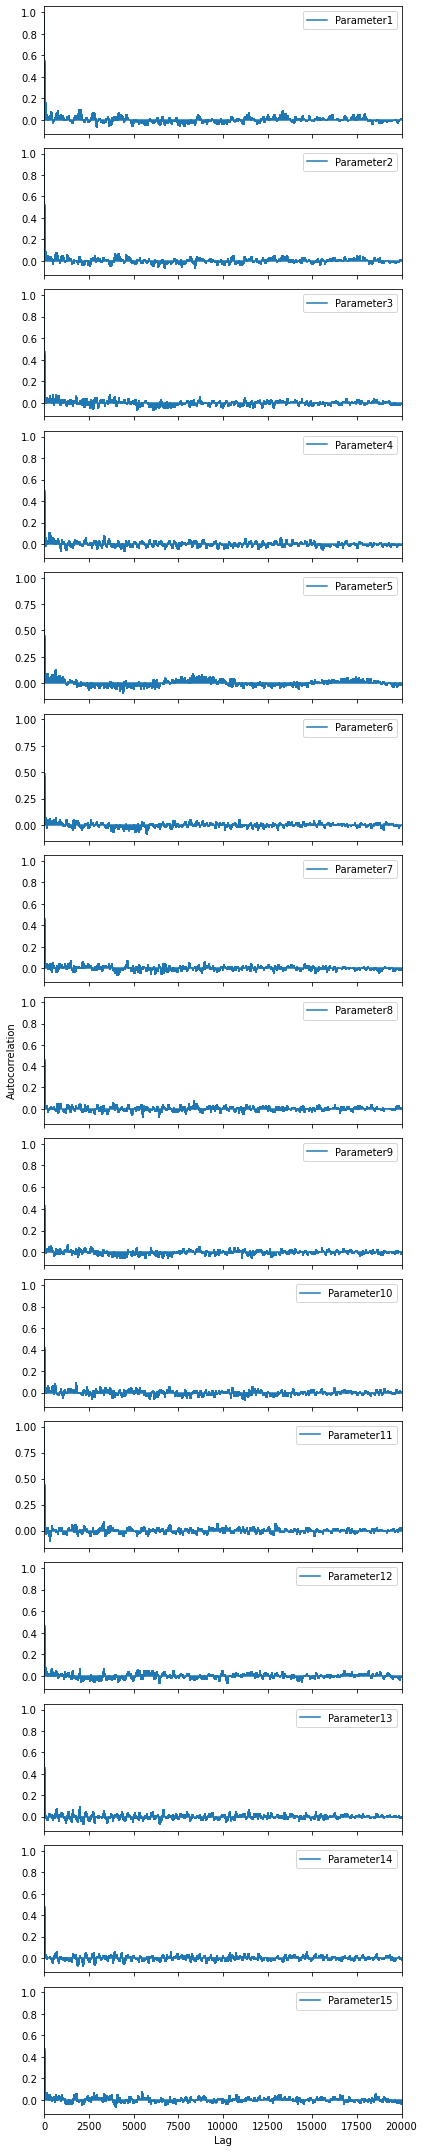

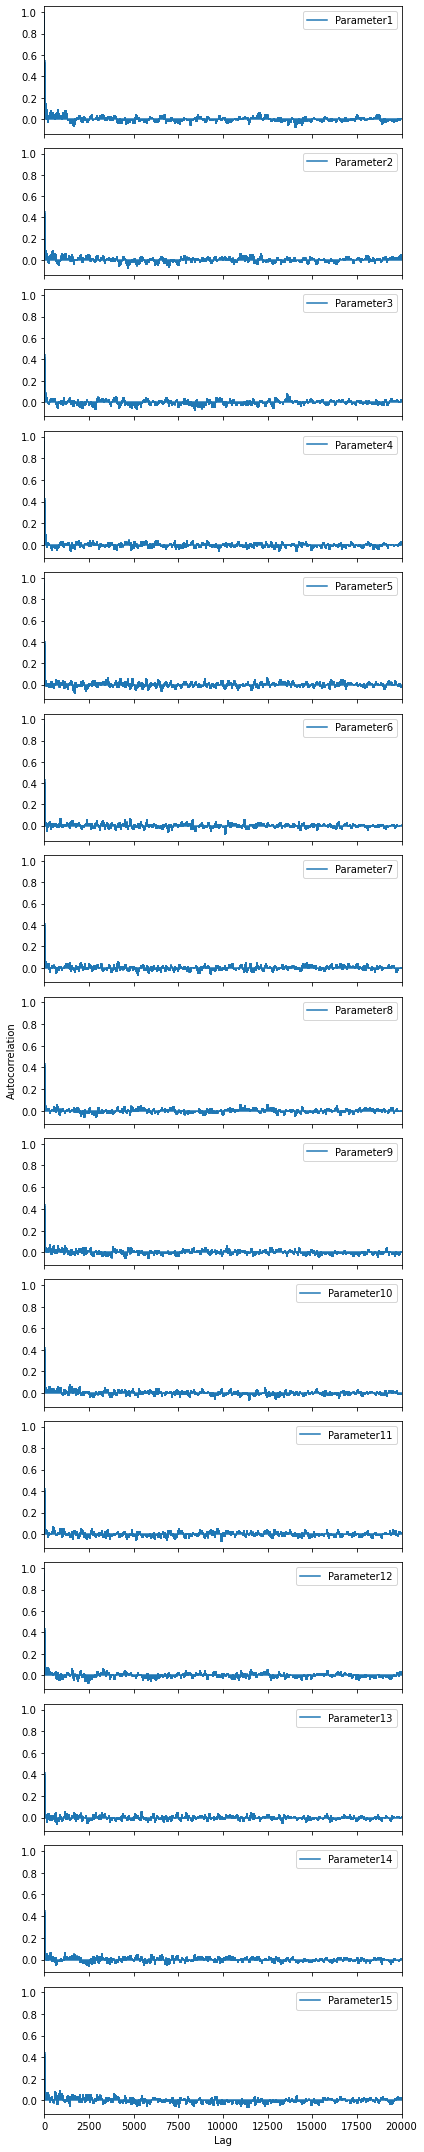

In [19]:
# Plot the autocorrelation for the three chains of parameters for London
for sample in samples_LON:
    pints.plot.autocorrelation(sample, max_lags=20000)
    plt.show()

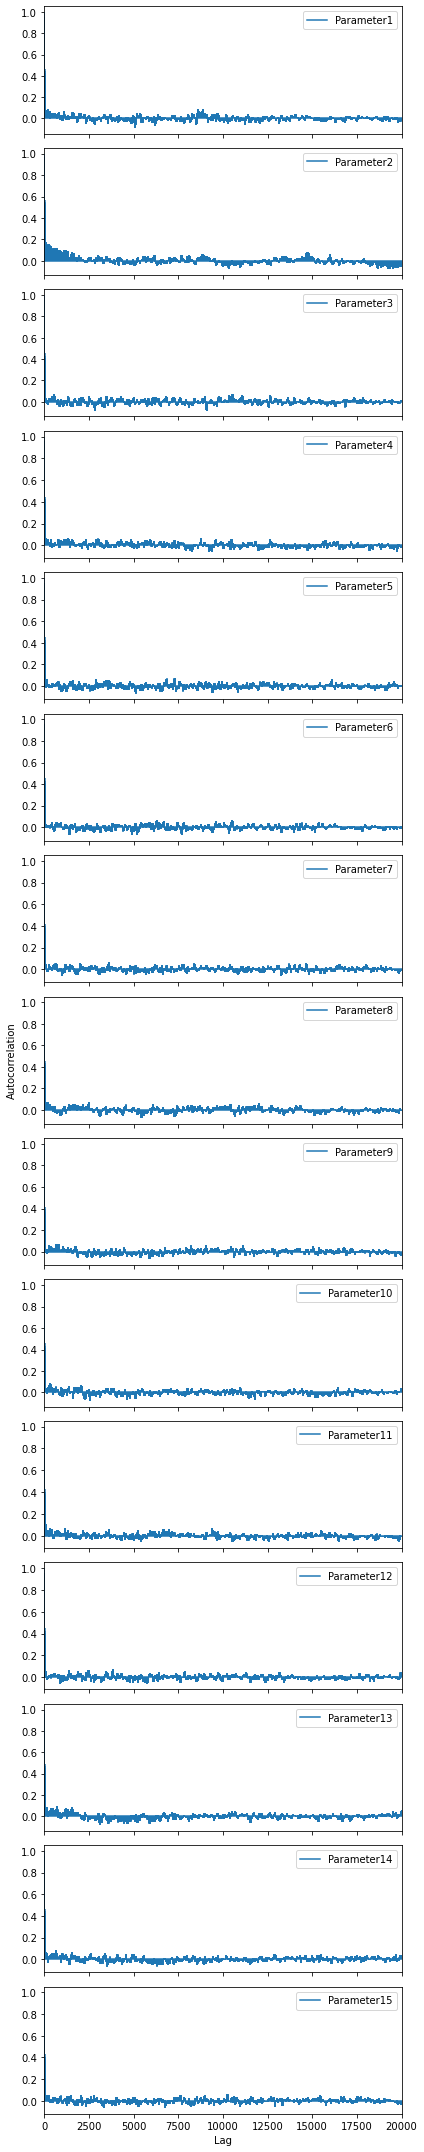

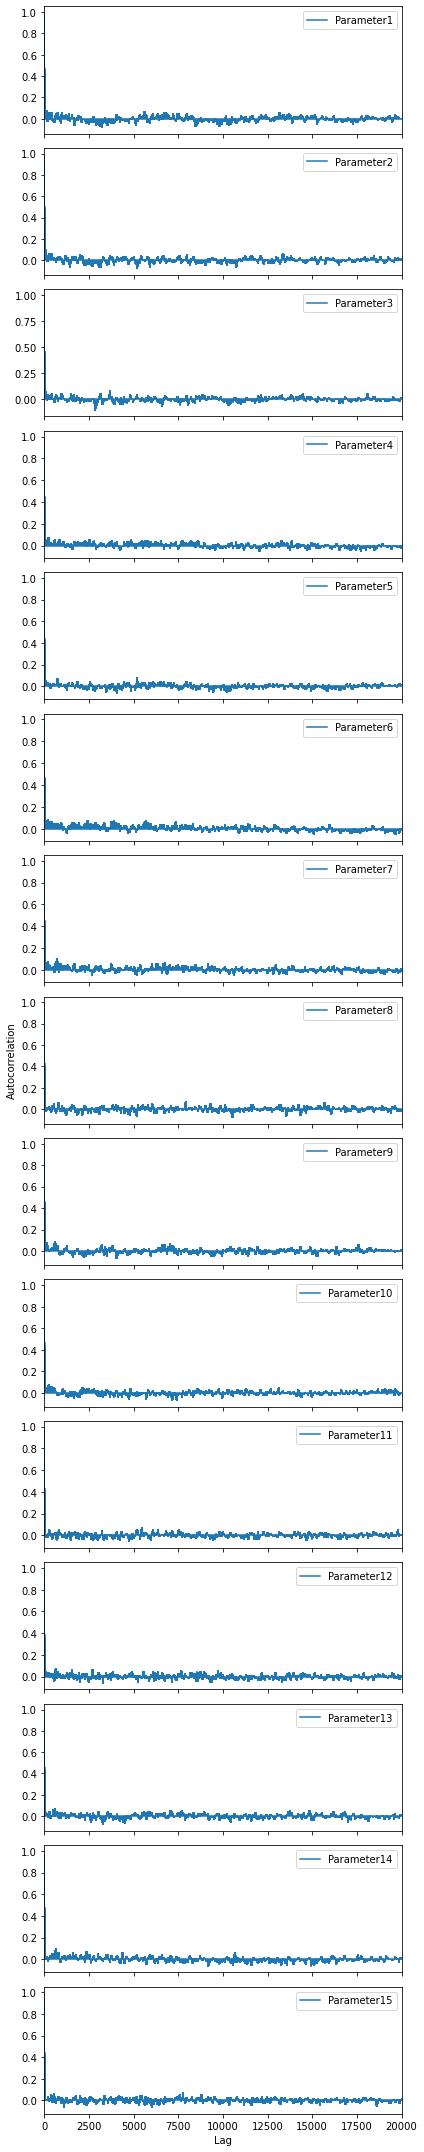

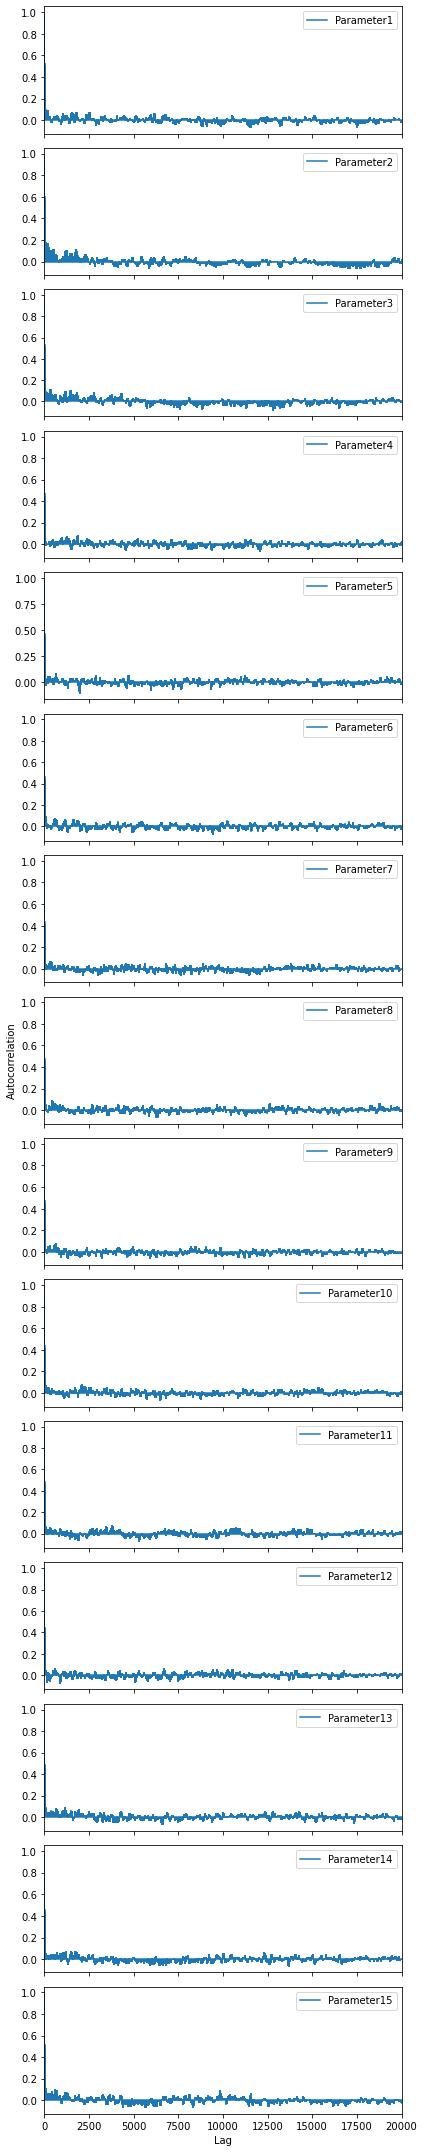

In [20]:
# Plot the autocorrelation for the three chains of parameters for North West
for sample in samples_NW:
    pints.plot.autocorrelation(sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

In [21]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples_LON.shape

extended_samples_LON = np.concatenate((samples_LON[0], samples_LON[1], samples_LON[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

predicted_new_infec = []
predicted_deaths = []
predicted_reprod_num = []

parameters = [
    [2.35], 0, [susceptibles[0]], np.zeros((1, len(age_groups))).tolist(), np.zeros((1, len(age_groups))).tolist(),
    [infectives1[0]], [infectives2[0]], np.zeros((1, len(age_groups))).tolist(), np.ones((1, len(times))).tolist(), dL, dI, 0.5]

# Simulate using the ODE solver from scipy
scipy_method = 'RK45'
parameters.append(scipy_method)

# Run model and number of new infections for London
reg_predicted_new_infec = []
reg_predicted_deaths = []
reg_predicted_reprod_num = []

parameters[1] = 1

for params in extended_samples_LON[::thinning, :]:
    parameters[0] = [params[0]] * len(model_LON.regions)
    LEN = len(np.arange(44, len(times), 7))

    betas = np.array(parameters[8])
    for r in range(len(model_LON.regions)):
        for d, day in enumerate(np.arange(44, len(times), 7)):
            betas[r, day:(day+7)] = params[r*LEN+d+1]

    parameters[8] = betas.tolist()

    r_fix = np.empty(len(times))
    model_reg_deaths_data = np.empty(len(times))

    m_fix = em.MultiTimesInfectivity(
        matrices_contact, time_changes_contact, regions_LON, matrices_region_LON, time_changes_region, parameters[0], dI, [susceptibles[0]])

    # Run model and number of new infections for all age groups
    model_output = model_LON.simulate(
        parameters=list(deepflatten(parameters, ignore=str)),
        times=times
    )
    age_model_reg_new_infections = model_LON.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        r_fix[t] = m_fix.compute_reproduction_number(1, time, model_output[t, :len(age_groups)], temp_variation=parameters[8][0][t])
        model_reg_deaths_data[t] = np.sum(model_LON.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))

    reg_predicted_new_infec.append(model_reg_new_infections)
    reg_predicted_deaths.append(model_reg_deaths_data)
    reg_predicted_reprod_num.append(r_fix)

reg_predicted_new_infec = np.array(reg_predicted_new_infec)

predicted_new_infec.append(reg_predicted_new_infec)
predicted_deaths.append(reg_predicted_deaths)
predicted_reprod_num.append(reg_predicted_reprod_num)

<ipython-input-21-d421b4a00c92>:53: ComplexWarning:

Casting complex values to real discards the imaginary part



In [22]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples_NW.shape

extended_samples_NW = np.concatenate((samples_NW[0], samples_NW[1], samples_NW[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

parameters = [
    2.35, 0, [susceptibles[1]], np.zeros((1, len(age_groups))).tolist(), np.zeros((1, len(age_groups))).tolist(),
    [infectives1[1]], [infectives2[1]], np.zeros((1, len(age_groups))).tolist(), np.ones((1, len(times))).tolist(), dL, dI, 0.5]

# Simulate using the ODE solver from scipy
scipy_method = 'RK45'
parameters.append(scipy_method)

# Run model and number of new infections for North West
reg_predicted_new_infec = []
reg_predicted_deaths = []
reg_predicted_reprod_num = []

parameters[1] = 1

for params in extended_samples_NW[::thinning, :]:
    parameters[0] = [params[0]] * len(model_NW.regions)
    LEN = len(np.arange(44, len(times), 7))

    betas = np.array(parameters[8])
    for r in range(len(model_NW.regions)):
        for d, day in enumerate(np.arange(44, len(times), 7)):
            betas[r, day:(day+7)] = params[r*LEN+d+1]

    parameters[8] = betas.tolist()

    r_fix = np.empty(len(times))
    model_reg_deaths_data = np.empty(len(times))

    m_fix = em.MultiTimesInfectivity(
        matrices_contact, time_changes_contact, regions_NW, matrices_region_NW, time_changes_region, parameters[0], dI, [susceptibles[1]])

    # Run model and number of new infections for all age groups
    model_output = model_NW.simulate(
        parameters=list(deepflatten(parameters, ignore=str)),
        times=times
    )
    age_model_reg_new_infections = model_NW.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)], temp_variation=parameters[8][0][t])
        model_reg_deaths_data[t] = np.sum(model_NW.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))

    reg_predicted_new_infec.append(model_reg_new_infections)
    reg_predicted_deaths.append(model_reg_deaths_data)
    reg_predicted_reprod_num.append(r_fix)

reg_predicted_new_infec = np.array(reg_predicted_new_infec)

predicted_new_infec.append(reg_predicted_new_infec)
predicted_deaths.append(reg_predicted_deaths)
predicted_reprod_num.append(reg_predicted_reprod_num)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
predicted_reprod_num = np.array(predicted_reprod_num)


<ipython-input-22-8e549caef801>:49: ComplexWarning:

Casting complex values to real discards the imaginary part



## Plot data vs predicted

### Setup ``plotly`` and default settings for plotting

In [23]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

In [24]:
# Set up traces to plot
new_infec_mean = []
deaths_mean = []
reprod_num_mean = []

new_infec_upper = []
deaths_upper = []
reprod_num_upper = []

new_infec_lower = []
deaths_lower = []
reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    new_infec_mean.append(np.mean(predicted_new_infec[r,:,:], axis=0))
    deaths_mean.append(np.mean(predicted_deaths[r,:,:], axis=0))
    reprod_num_mean.append(np.mean(predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    new_infec_upper.append(np.quantile(predicted_new_infec[r,:,:], 0.975, axis=0))
    deaths_upper.append(np.quantile(predicted_deaths[r,:,:], 0.975, axis=0))
    reprod_num_upper.append(np.quantile(predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    new_infec_lower.append(np.quantile(predicted_new_infec[r,:,:], 0.025, axis=0))
    deaths_lower.append(np.quantile(predicted_deaths[r,:,:], 0.025, axis=0))
    reprod_num_lower.append(np.quantile(predicted_reprod_num[r,:,:], 0.025, axis=0))

### Plot observed versus predicted using model with inferred parameters

In [25]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=new_infec_upper[r].tolist() + new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=deaths_upper[r].tolist() + deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=reprod_num_upper[r].tolist() + reprod_num_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-3.pdf')
fig.show()

<ipython-input-25-c60bfc04672e>:42: RuntimeWarning:

invalid value encountered in true_divide

